# HackerEarth Deep Learning challenge: Identify the dance form
This International Dance Day, an event management company organized an evening of Indian classical dance performances to celebrate the rich, eloquent, and elegant art of dance. Post the event, the company planned to create a microsite to promote and raise awareness among the public about these dance forms. However, identifying them from images is a tough nut to crack.
You have been appointed as a Machine Learning Engineer for this project. Build an image tagging Deep Learning model that can help the company classify these images into eight categories of Indian classical dance.

### Dataset
The dataset consists of 364 images belonging to 8 categories, namely manipuri, bharatanatyam, odissi, kathakali, kathak, sattriya, kuchipudi, and mohiniyattam.
The benefits of practicing this problem by using Machine Learning/Deep Learning techniques are as follows:
This challenge will encourage you to apply your Machine Learning skills to build models that classify images into multiple categories
This challenge will help you enhance your knowledge of classification actively. It is one of the basic building blocks of Machine Learning and Deep Learning
We challenge you to build a model that auto-tags images and classifies them into various categories of Indian classical dance forms.

The data folder consists of two folders and two .csv files. The details are as follows:
train: Contains 364 images for 8 classes 
* manipuri,
* bharatanatyam
* odissi
* kathakali
* kathak
* sattriya
* kuchipudi
* mohiniyattam

test: Contains 156 images
train.csv: 364 x 2
test.csv: 156 x 1

Data description
This data set consists of the following two columns:

| Column Name | Description |
|-------------|-------------|
| Image       | Name of Image| 
|target       |Category of Image  ['manipuri','bharatanatyam','odissi','kathakali','kathak','sattriya','kuchipudi','mohiniyattam'] |


In this file we are using Transfer Learning concept to classify Indian dance form. Transfer Learning used when we have very less training data. In image processing, training with less data does not give good results. So we are using Transfer Learning to get weights. This notebook use *tensorflow* *VGG16* and the purpose of this notbook to show how to use Transfer Learning for image classification 

In [2]:
# import required libraries 
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from sklearn.preprocessing import LabelEncoder

In [20]:
# Load train and test csv file for image class
train = pd.read_csv('/kaggle/input/identifythedanceform/train.csv')
test = pd.read_csv('/kaggle/input/identifythedanceform/test.csv')

print(train.head())
print(test.head())
print(train['target'].value_counts())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi
     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg
mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


In [21]:
train.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


Basic Histrogram plot to check number of training data for each dance form. 

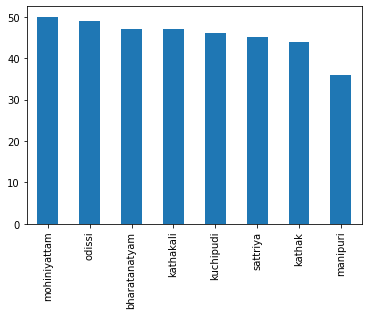

In [4]:
#Histogram chart for target
train['target'].value_counts().plot(kind='bar')

In [5]:
base='/kaggle/input/identifythedanceform'
train_dir = os.path.join(str(base)+ '/train/')
test_dir = os.path.join(str(base)+'/test/')

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['230.jpg', '443.jpg', '455.jpg', '27.jpg', '504.jpg', '268.jpg', '186.jpg', '127.jpg', '305.jpg']
['238.jpg', '495.jpg', '64.jpg', '6.jpg', '125.jpg', '226.jpg', '398.jpg', '38.jpg', '349.jpg']


In [7]:
# Images migh be in different size. In this section I assigning all image at same size of 224*224
img_width = 224
img_height = 224

Below two section used for data preprocessing. We are reading image data using OpenCV and converting into numeric formate.

In [23]:
# this function reads image from the disk,train file for image and class maping and returning output in numpy array formate
# for input and target data
def train_data_preparation(list_of_images, train, train_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    for image in list_of_images:
        x.append((cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)).astype('float32'))

        if image in list(train['Image']):
            y.append(train.loc[train['Image'] == image, 'target'].values[0])
    
            
    return x, y

In [9]:
def test_data_prepare(list_of_images, test_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    
    for image in list_of_images:
        x.append((cv2.resize(cv2.imread(test_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)).astype('float32'))    
            
    return x

In [24]:
training_data, training_labels = train_data_preparation(train_fnames, train, train_dir)

In [25]:
training_labels[:20]

['kathakali',
 'kuchipudi',
 'odissi',
 'kathak',
 'odissi',
 'mohiniyattam',
 'kathakali',
 'bharatanatyam',
 'mohiniyattam',
 'odissi',
 'kathakali',
 'kuchipudi',
 'mohiniyattam',
 'sattriya',
 'kuchipudi',
 'kathak',
 'kathak',
 'mohiniyattam',
 'kuchipudi',
 'mohiniyattam']

In [26]:
training_data[0]

array([[[49., 61., 73.],
        [62., 74., 86.],
        [38., 50., 62.],
        ...,
        [ 6., 13., 28.],
        [ 6., 13., 28.],
        [ 6., 13., 28.]],

       [[47., 59., 72.],
        [49., 61., 73.],
        [34., 46., 58.],
        ...,
        [ 6., 13., 28.],
        [ 6., 13., 28.],
        [ 6., 13., 28.]],

       [[49., 61., 72.],
        [43., 55., 67.],
        [39., 51., 62.],
        ...,
        [ 6., 13., 28.],
        [ 6., 13., 28.],
        [ 6., 13., 28.]],

       ...,

       [[21., 29., 40.],
        [ 8., 17., 32.],
        [ 8., 20., 38.],
        ...,
        [ 7.,  8., 18.],
        [ 7.,  8., 18.],
        [ 7.,  8., 18.]],

       [[22., 32., 43.],
        [ 9., 20., 35.],
        [19., 30., 49.],
        ...,
        [ 7.,  8., 18.],
        [ 7.,  8., 18.],
        [ 7.,  8., 18.]],

       [[24., 34., 47.],
        [14., 25., 40.],
        [26., 37., 58.],
        ...,
        [ 7.,  8., 18.],
        [ 7.,  8., 18.],
        [ 7.,  8., 18.]]

In [27]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

Just showing loaded data for first 25 image

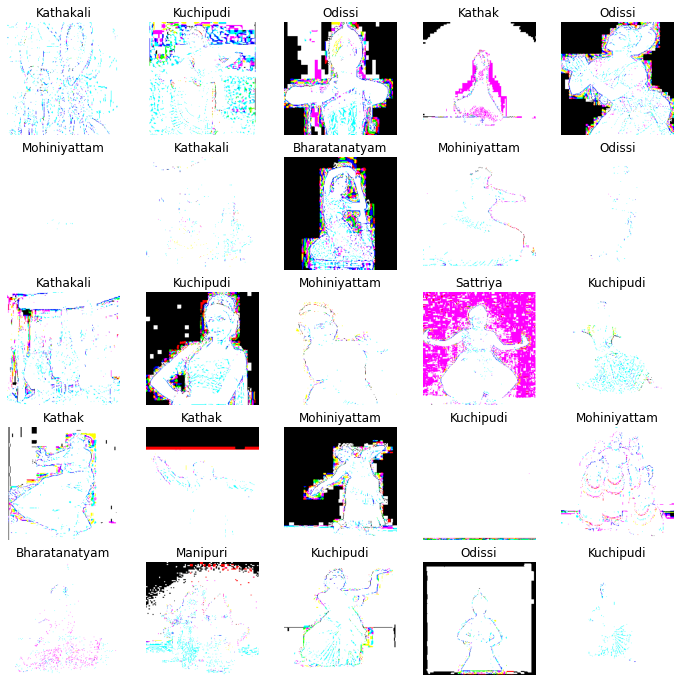

In [28]:
show_batch(training_data, training_labels)

In [29]:
testing_data = test_data_prepare(test_fnames, test_dir)

Using label incoder converting target class to numeric format

In [30]:
le =LabelEncoder()
training_labels=le.fit_transform(training_labels)

In this section I am using ougumentation techniques to generate more data for given input

In [31]:
datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.10,  
        height_shift_range=0.10,  
        horizontal_flip=True,  
        vertical_flip=False) 


test_datagenerator=ImageDataGenerator(
        rescale=1. / 255
)
datagenerator.fit(training_data)
test_datagenerator.fit(training_data)
training_data=np.array(training_data)
testing_data=np.array(testing_data)

In [51]:
# subsetting validation data
validation_data = training_data[300:]
validation_label =training_labels[300:]

In [53]:
training_data = training_data[:300]
training_labels = training_labels[:300]

In [55]:
print(training_data.shape)
print(training_labels.shape)
print(validation_data.shape)
print(validation_label.shape)

(300, 224, 224, 3)
(300,)
(64, 224, 224, 3)
(64,)


In below code we are loading *VGG16* weights for image classifier using transfer learning

In [33]:
# traing using transfer learning

vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3),pooling='avg')

 # Print the model summary
vggmodel.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Using already trained model for our task and bulding 2 fully connected layer with *softmax* activation function

In [34]:
vggmodel.trainable = False
model = Sequential([
  vggmodel, 
  Dense(1024, activation='relu'),
  Dropout(0.4),
  Dense(256, activation='relu'),
  Dense(8, activation='softmax'),
])

In [35]:

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In the below code we are compiling and traing our image data

In [56]:
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history =model.fit_generator(
    datagenerator.flow(training_data, to_categorical(training_labels,8), batch_size=32),
    validation_data=datagenerator.flow(validation_data, to_categorical(validation_label,8), batch_size=32),
    verbose=2,
    epochs=30,
    callbacks=callbacks
)

Train for 10 steps, validate for 2 steps
Epoch 1/30
10/10 - 5s - loss: 0.3057 - accuracy: 0.8867 - val_loss: 0.4753 - val_accuracy: 0.8281
Epoch 2/30
10/10 - 5s - loss: 0.2432 - accuracy: 0.9133 - val_loss: 0.1841 - val_accuracy: 0.9375
Epoch 3/30
10/10 - 5s - loss: 0.1873 - accuracy: 0.9300 - val_loss: 0.2080 - val_accuracy: 0.9219
Epoch 4/30
10/10 - 4s - loss: 0.1998 - accuracy: 0.9333 - val_loss: 0.1993 - val_accuracy: 0.9531
Epoch 5/30
10/10 - 4s - loss: 0.1633 - accuracy: 0.9533 - val_loss: 0.1470 - val_accuracy: 0.9375
Epoch 6/30
10/10 - 4s - loss: 0.1376 - accuracy: 0.9533 - val_loss: 0.1939 - val_accuracy: 0.9219
Epoch 7/30
10/10 - 4s - loss: 0.1592 - accuracy: 0.9367 - val_loss: 0.2960 - val_accuracy: 0.8750
Epoch 8/30

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10/10 - 4s - loss: 0.1741 - accuracy: 0.9333 - val_loss: 0.2609 - val_accuracy: 0.8906
Epoch 9/30
10/10 - 4s - loss: 0.1282 - accuracy: 0.9600 - val_loss: 0.1650 - val_accuracy: 0.

Text(0.5, 1.0, 'Training and validation loss')

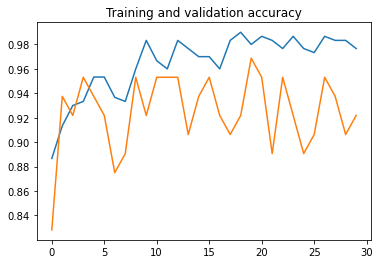

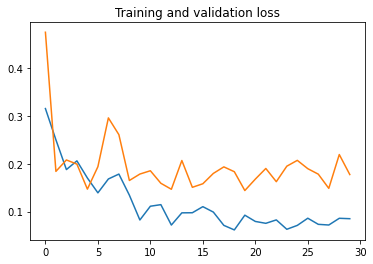

In [57]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [58]:
labels = model.predict(testing_data)
label = [np.argmax(i) for i in labels]


In [59]:
target=le.inverse_transform(label)

In [60]:
target[:25]

array(['kathakali', 'odissi', 'kathakali', 'kathakali', 'bharatanatyam',
       'kathakali', 'bharatanatyam', 'bharatanatyam', 'bharatanatyam',
       'kuchipudi', 'bharatanatyam', 'kuchipudi', 'sattriya',
       'mohiniyattam', 'mohiniyattam', 'bharatanatyam', 'kuchipudi',
       'bharatanatyam', 'bharatanatyam', 'kathakali', 'kathakali',
       'kathakali', 'kathakali', 'bharatanatyam', 'bharatanatyam'],
      dtype='<U13')

In [61]:
submission = pd.DataFrame({ 'Image': test.Image, 'target': target })
submission.to_csv('output2.csv', index=False)